# Data Cleaning

In [1]:
%%time
%pwd
from pyspark import SparkContext
sc = SparkContext(pyFiles=['/mnt/workspace/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section2-PCA/PCA/data_preparation/lib/numpy_pack.py'])

from pyspark import SparkContext
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

CPU times: user 164 ms, sys: 24 ms, total: 188 ms
Wall time: 13.2 s


In [2]:
#sc.stop()


In [3]:
!du -s /mnt/workspace/Data/*

1612	/mnt/workspace/Data/stations.parquet
2248960	/mnt/workspace/Data/weather.parquet


In [4]:
!hdfs dfs -ls /weather/
!hdfs dfs -du /weather/

Found 2 items
drwxr-xr-x   - hadoop hadoop          0 2018-03-07 20:34 /weather/stations.parquet
drwxr-xr-x   - hadoop hadoop          0 2018-03-07 20:34 /weather/weather.parquet
1641738     /weather/stations.parquet
2302800781  /weather/weather.parquet


In [5]:
%%time
!hdfs dfs -mkdir /weather
!hdfs dfs -copyFromLocal /mnt/workspace/Data/stations.parquet /weather/
!hdfs dfs -copyFromLocal /mnt/workspace/Data/weather.parquet /weather/

mkdir: `/weather': File exists
copyFromLocal: `/weather/stations.parquet/_SUCCESS': File exists
copyFromLocal: `/weather/stations.parquet/_common_metadata': File exists
copyFromLocal: `/weather/stations.parquet/_metadata': File exists
copyFromLocal: `/weather/stations.parquet/part-r-00000-1fd04699-91d3-4a2a-9b36-e25c9c5f0376.gz.parquet': File exists
copyFromLocal: `/weather/stations.parquet/part-r-00001-1fd04699-91d3-4a2a-9b36-e25c9c5f0376.gz.parquet': File exists
copyFromLocal: `/weather/weather.parquet/_SUCCESS': File exists
copyFromLocal: `/weather/weather.parquet/part-00000-6cb19187-62a0-42ad-9516-e03e05ea0c40-c000.snappy.parquet': File exists
copyFromLocal: `/weather/weather.parquet/part-00001-6cb19187-62a0-42ad-9516-e03e05ea0c40-c000.snappy.parquet': File exists
copyFromLocal: `/weather/weather.parquet/part-00002-6cb19187-62a0-42ad-9516-e03e05ea0c40-c000.snappy.parquet': File exists
copyFromLocal: `/weather/weather.parquet/part-00003-6cb19187-62a0-42ad-9516-e03e05ea0c40-c000.snap

In [6]:
%%time
Query="""
SELECT measurement,count(measurement) as Count 
FROM parquet.`/weather/weather.parquet` 
GROUP BY measurement
"""
Counts_pdf = sqlContext.sql(Query).toPandas()

CPU times: user 144 ms, sys: 24 ms, total: 168 ms
Wall time: 25 s


In [7]:
Counts_pdf.sort_values('Count',ascending=False,inplace=True)
_index=[i for i in range(Counts_pdf.shape[0])]
Counts_pdf['Index']=_index
Counts_pdf.set_index('Index',inplace=True)

In [8]:
Counts_pdf.head(7)

,measurement,Count
Index,,
0,PRCP,2521007
1,TMIN,969579
2,TMAX,967931
3,SNOW,881399
4,SNWD,864192
5,TOBS,478981
6,MDPR,349252


In [9]:
Top30=list(Counts_pdf['measurement'][:30])
restrictions='\n\t or '.join(["measurement='%s'"%name for name in Top30])
#print(restrictions)

In [10]:
%%time
Query="""
SELECT *
FROM parquet.`/weather/weather.parquet` 
WHERE ("""+restrictions+")" # and Station='USW00093819'"
print(Query)
Weather_df = sqlContext.sql(Query).cache()
print 'number of records=',Weather_df.count()


SELECT *
FROM parquet.`/weather/weather.parquet` 
WHERE (measurement='PRCP'
	 or measurement='TMIN'
	 or measurement='TMAX'
	 or measurement='SNOW'
	 or measurement='SNWD'
	 or measurement='TOBS'
	 or measurement='MDPR'
	 or measurement='DAPR'
	 or measurement='WT03'
	 or measurement='WT01'
	 or measurement='DWPR'
	 or measurement='WT04'
	 or measurement='WT05'
	 or measurement='WT11'
	 or measurement='WT06'
	 or measurement='WT16'
	 or measurement='WESD'
	 or measurement='WT08'
	 or measurement='WT18'
	 or measurement='WT14'
	 or measurement='WESF'
	 or measurement='WT09'
	 or measurement='PGTM'
	 or measurement='EVAP'
	 or measurement='WDMV'
	 or measurement='WT02'
	 or measurement='MDSF'
	 or measurement='WT07'
	 or measurement='AWND'
	 or measurement='DASF')
number of records= 9066597
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.72 s


In [11]:
%%time
Weather_df.show(1)

+-----------+-----------+----+--------------------+
|    Station|Measurement|Year|              Values|
+-----------+-----------+----+--------------------+
|USW00093819|       WESD|1952|[00 7E 00 7E 00 7...|
+-----------+-----------+----+--------------------+
only showing top 1 row

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 130 ms


In [12]:
import sys
sys.path.append('./lib')
from numpy_pack import unpackArray

import numpy as np

### Using User Defined Functions (UDF)
* define a python function that operates on the `Values` field.
```python
def Count_nan(V):
    A=unpackArray(V,data_type=np.float16)
    return int(sum(np.isnan(A)))
```

* define and register the function as a UDF
```python
Count_nan_udf = udf(Count_nan,IntegerType())
```

* apply the UDF and create a new column
```python
Weather_df=Weather_df.withColumn("nan_no", Count_nan_udf(Weather_df.Values))
```

In [13]:
%%time
from pyspark.sql.types import ArrayType,FloatType, DoubleType, StringType, IntegerType
from pyspark.sql.functions import udf
import numpy as np

def Count_nan(V):
    A=unpackArray(V,data_type=np.float16)
    return int(sum(np.isnan(A)))  # the int() is important, sparksql does not accept numpy ints

Count_nan_udf = udf(Count_nan,IntegerType())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 53.9 µs


In [14]:
%%time
# The following is a debug code which takes one row and runs Count_nan on it
Row,=Weather_df.take(1)
print(Count_nan(Row.Values))

239
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 43.8 ms


In [15]:
Weather_df=Weather_df.withColumn("nan_no", Count_nan_udf(Weather_df.Values))

In [16]:
# the following registrations allow using `UnpackArray` and `weather` in an SQL query (not used here)
sqlContext.registerFunction("UnpackArray", Count_nan,IntegerType())
sqlContext.registerDataFrameAsTable(Weather_df,'weather')

In [17]:
%%time
Weather_df.count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 217 ms


9066597

In [18]:
Weather_df.schema

StructType(List(StructField(Station,StringType,true),StructField(Measurement,StringType,true),StructField(Year,IntegerType,true),StructField(Values,BinaryType,true),StructField(nan_no,IntegerType,true)))

## Undef Statistics

In [19]:
%%time
Weather_df.cache().take(1)

CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 5min 58s


[Row(Station=u'USW00093819', Measurement=u'WESD', Year=1952, Values=bytearray(b'\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~\x00~*j*j*j*j*j*j*j*

In [20]:
%%time
nan_rdd=Weather_df.select(['Station','Measurement','Year','nan_no']).rdd

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 41.1 ms


In [21]:
def map_to_hist(n):
    a=np.zeros(366)
    a[n]=1
    return a
by_measurement=nan_rdd.map(lambda row: (row.Measurement,map_to_hist(row.nan_no)))
#by_measurement.take(2)

In [22]:
%%time
Hists=by_measurement.reduceByKey(lambda x,y:x+y).collect()

CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 8min 2s


## Manipulating as DataFrames
using UDF

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
HistMap={a:b for a,b in Hists}
HistMap.keys()

[u'TMIN',
 u'SNWD',
 u'PGTM',
 u'DAPR',
 u'WT09',
 u'WT08',
 u'WT05',
 u'WT04',
 u'WT07',
 u'WT06',
 u'WT01',
 u'MDPR',
 u'WT03',
 u'WT02',
 u'TOBS',
 u'EVAP',
 u'DWPR',
 u'AWND',
 u'DASF',
 u'WESF',
 u'TMAX',
 u'MDSF',
 u'SNOW',
 u'WT11',
 u'WT16',
 u'WT14',
 u'WDMV',
 u'WESD',
 u'WT18',
 u'PRCP']

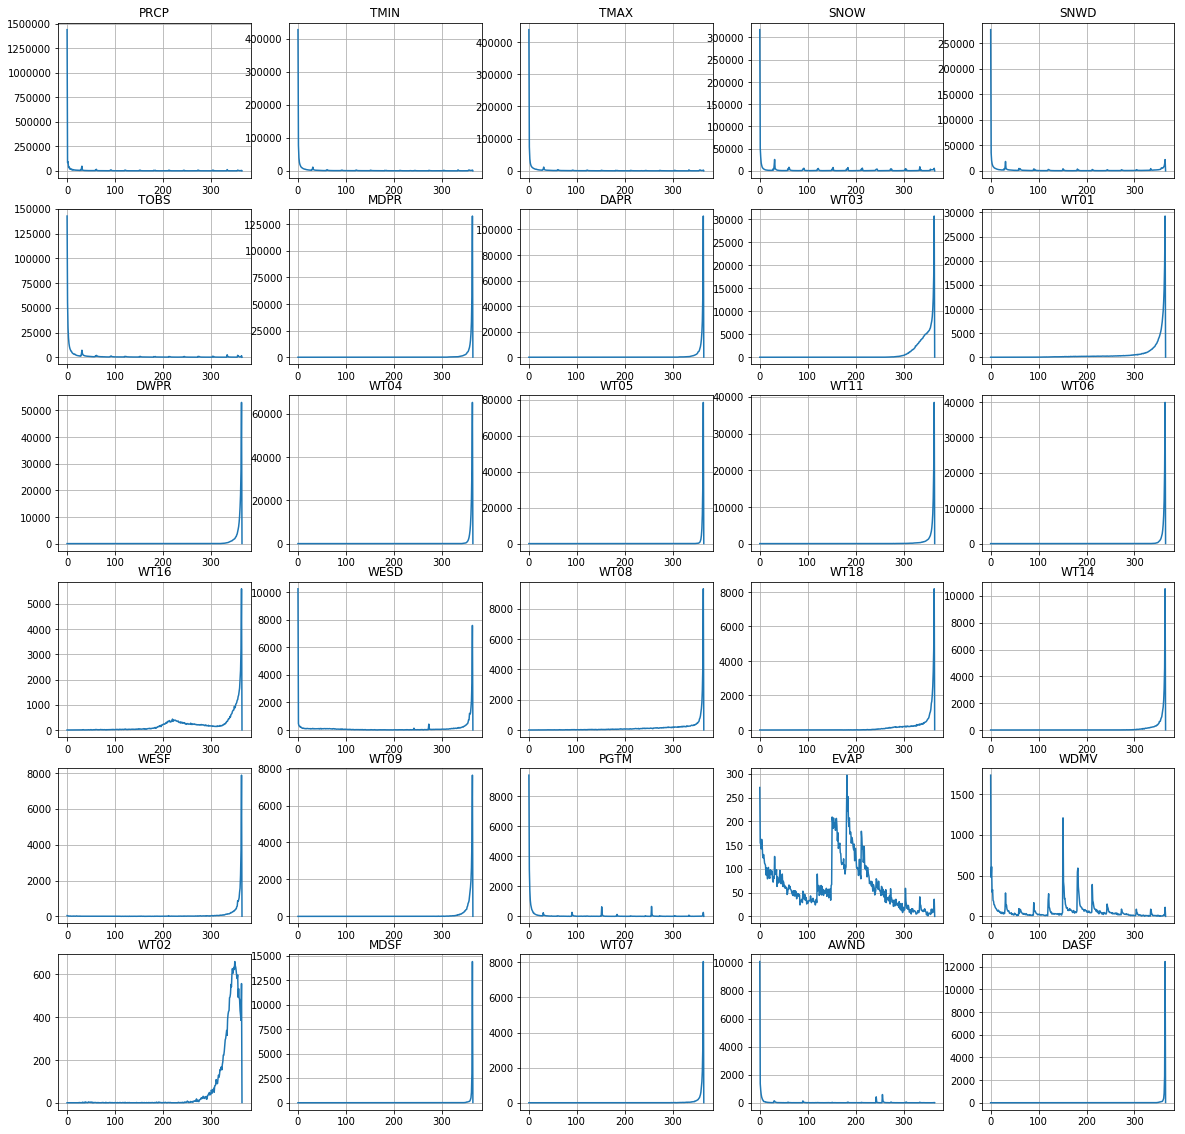

In [25]:
figure(figsize=[20,20])
for i in range(len(Hists)):
    measurement=Top30[i]
    subplot(6,5,i+1)
    plot(HistMap[measurement])
    title(measurement)
    grid()


## Computing the statistics